In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
from sklearn import linear_model
import numpy as np
import string
import random
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

In [4]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [5]:
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d

In [6]:
answers = {}

In [7]:
# Some data structures that will be useful

In [8]:
allHours = []
for l in readJSON("train.json.gz"):
    allHours.append(l)

In [9]:
hoursTrain = allHours[:165000]
hoursValid = allHours[165000:]

In [10]:
hoursPerUser = defaultdict(list)
hoursPerItem = defaultdict(list)
for u,g,d in hoursTrain:
    r = d['hours_transformed']
    hoursPerUser[u].append((g, r))
    hoursPerItem[g].append((u, r))

In [11]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,g,d in hoursTrain:
    itemsPerUser[u].append(g)
    usersPerItem[g].append(u)

In [12]:
userIDs, itemIDs = {}, {}
interactions = []

for u,g,d in allHours:
    r = d['hours_transformed']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not g in itemIDs: itemIDs[g] = len(itemIDs)
    interactions.append((u,g,r))

In [12]:
##################################################
# Play prediction                                #
##################################################

In [13]:
# Generate a negative set
userSet = set()
gameSet = set()
playedSet = set()

for u,g,d in allHours:
    userSet.add(u)
    gameSet.add(g)
    playedSet.add((u, g))

lUserSet = list(userSet)
lGameSet = list(gameSet)

notPlayed = set()
for u,g,d in hoursValid:
    g = random.choice(lGameSet)
    while (u,g) in playedSet or (u,g) in notPlayed:
        g = random.choice(lGameSet)
    notPlayed.add((u,g))

playedValid = set()
for u,g,r in hoursValid:
    playedValid.add((u,g))

In [15]:
### Question 1

In [16]:
# From baseline code
def baseline_tune(coeff=2):
    gameCount = defaultdict(int)
    totalPlayed = 0

    for u,g,_ in hoursTrain:
        gameCount[g] += 1
        totalPlayed += 1

    mostPopular = [(gameCount[x], x) for x in gameCount]
    mostPopular.sort()
    mostPopular.reverse()

    return1 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed/coeff: break
    return return1

In [17]:
# Evaluate baseline strategy
def baseline_eval(return1):
    correct = 0
    p0, p1 = 0, 0
    for (label, sample) in [(1, playedValid), (0, notPlayed)]:
        for (u,b) in sample:
            pred = 0
            if b in return1:
                pred = 1
            if pred == label:
                correct += 1
    return correct / (len(playedValid) + len(notPlayed))

In [413]:
correct / (len(playedValid) + len(notPlayed))

6.684418441844184

In [428]:
bestCoef = 2
bestAcc = None
for coef in np.arange(1.4, 1.52, 0.0001):
    return1 = baseline_tune(coef)
    acc = baseline_eval(return1)
    if bestAcc == None or acc > bestAcc:
        bestCoef = coef
        bestAcc = acc 

In [431]:
bestAcc, bestCoef

(0.7007200720072008, 1.4844999999999906)

In [33]:
answers['Q1'] = correct / (len(playedValid) + len(notPlayed))
answers['Q1']

0.6807680768076808

In [34]:
assertFloat(answers['Q1'])

In [15]:
gameCount = defaultdict(int)
totalPlayed = 0

for u,g,_ in hoursTrain:
    gameCount[g] += 1
    totalPlayed += 1

mostPopular = [(gameCount[x], x) for x in gameCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPlayed/1.4844999999999906: break

In [20]:
### Question 2

In [37]:
# Evaluate baseline strategy

correct = 0
p0, p1 = 0,0
for (label, sample) in [(1, playedValid), (0, notPlayed)]:
    for (u,b) in sample:
        pred = 0
        if b in return1:
            pred = 1
        if pred == label:
            correct += 1

In [39]:
correct / (len(playedValid) + len(notPlayed))

0.6914691469146915

In [40]:
answers['Q2'] = [1.5 * totalPlayed/2, correct / (len(playedValid) + len(notPlayed))]
answers['Q2']

[123750.0, 0.6914691469146915]

In [42]:
assertFloatList(answers['Q2'], 2)

In [25]:
### Question 3/4

In [137]:
# Slow implementation, could easily be improved following the code from Lecture 7

correct = 0
p0, p1 = 0,0
for (label, sample) in [(1, playedValid), (0, notPlayed)]:
    for (u,g) in sample:
        maxSim = 0
        users = set(hoursPerItem[g])
        for g2,_ in hoursPerItem[u]:
            sim = Jaccard(users, set(hoursPerItem[g2]))
            if sim > maxSim:
                maxSim = sim
        pred = 0
        if maxSim > 0.0025 or len(hoursPerItem[g]) > 79.8:
            pred = 1
            p1 += 1
        else:
            p0 += 1
        if pred == label:
            correct += 1

In [138]:
correct / (len(playedValid) + len(notPlayed))

0.7011201120112012

In [139]:
answers['Q3'] = correct / (len(playedValid) + len(notPlayed))
answers['Q4'] = correct / (len(playedValid) + len(notPlayed))

In [140]:
assertFloat(answers['Q3'])
assertFloat(answers['Q4'])

In [154]:
hoursTrain[0]

('u70666506',
 'g49368897',
 {'userID': 'u70666506',
  'early_access': False,
  'hours': 63.5,
  'hours_transformed': 6.011227255423254,
  'found_funny': 1,
  'text': 'If you want to sit in queue for 10-20min and have 140 ping then this game is perfect for you :)',
  'gameID': 'g49368897',
  'user_id': '76561198030408772',
  'date': '2017-05-20'})

### Unique labels of the dictionary and their counts

In [161]:
labels = defaultdict(int)
funny_scores = defaultdict(int)
for u,g,d in allHours:
    for label in d:
        if label not in labels:
            labels[label] = 1
        else:
            labels[label] += 1
        if label == 'found_funny':
            score = d['found_funny']
            if score not in funny_scores:
                funny_scores[score] = 1
            else:
                funny_scores[score] += 1
labels

defaultdict(int,
            {'userID': 174999,
             'early_access': 174999,
             'hours': 174999,
             'hours_transformed': 174999,
             'found_funny': 29938,
             'text': 174999,
             'gameID': 174999,
             'user_id': 54841,
             'date': 174999,
             'compensation': 2870})

In [169]:
funny_scores
# Idea: only keep 1 as funny indicator, as numbers spread without much interpretation, though smaller numbers
# have higher frequency.

defaultdict(int,
            {1: 16381,
             6: 571,
             4: 1338,
             23: 45,
             2: 5049,
             3: 2267,
             17: 76,
             62: 8,
             5: 865,
             333: 1,
             21: 40,
             19: 56,
             39: 15,
             10: 212,
             11: 166,
             13: 128,
             401: 1,
             7: 405,
             219: 1,
             53: 12,
             416: 2,
             26: 36,
             30: 14,
             22: 54,
             45: 16,
             9: 265,
             15: 87,
             8: 342,
             34: 15,
             253: 2,
             311: 1,
             12: 158,
             31: 24,
             24: 29,
             20: 36,
             29: 29,
             46: 14,
             25: 33,
             16: 65,
             41: 15,
             48: 15,
             14: 111,
             350: 1,
             237: 3,
             982: 1,
             188: 3,
        

In [168]:
labels = defaultdict(int)
comp_text = defaultdict(int)
for u,g,d in allHours:
    for label in d:
        if label not in labels:
            labels[label] = 1
        else:
            labels[label] += 1
        if label == 'compensation':
            text = d['compensation']
            if text not in comp_text:
                comp_text[text] = 1
            else:
                comp_text[text] += 1
            # print(d['compensation'])
comp_text

defaultdict(int, {'Product received for free': 2870})

In [170]:
allHours[0]

('u70666506',
 'g49368897',
 {'userID': 'u70666506',
  'early_access': False,
  'hours': 63.5,
  'hours_transformed': 6.011227255423254,
  'found_funny': 1,
  'text': 'If you want to sit in queue for 10-20min and have 140 ping then this game is perfect for you :)',
  'gameID': 'g49368897',
  'user_id': '76561198030408772',
  'date': '2017-05-20'})

In [215]:
year_analysis = defaultdict(list)
year_review = defaultdict(list)
year_count = defaultdict(int)
for u,g,d in allHours:
    year = d['date'][:4]
    year_analysis[year].append(d['hours'])
    year_count[year] += 1
    year_review[year].append(d)
year_analysis.keys()

dict_keys(['2017', '2014', '2015', '2016', '2011', '2013', '2012', '2018', '2010'])

In [173]:
# Average hours played in each year
for year in year_analysis:
    year_analysis[year] = sum(year_analysis[year]) / len(year_analysis[year])
year_analysis

defaultdict(list,
            {'2017': 83.79954260953483,
             '2014': 46.56876484994707,
             '2015': 53.93078762119795,
             '2016': 75.37695742780686,
             '2011': 46.98958254983074,
             '2013': 48.452502805836104,
             '2012': 49.38314573459728,
             '2018': 91.10154738878141,
             '2010': 61.486481113320096})

In [176]:
year_count # count of user/game interactions in each year

defaultdict(int,
            {'2017': 49848,
             '2014': 27357,
             '2015': 37645,
             '2016': 43667,
             '2011': 2659,
             '2013': 8910,
             '2012': 3376,
             '2018': 1034,
             '2010': 503})

<BarContainer object of 9 artists>

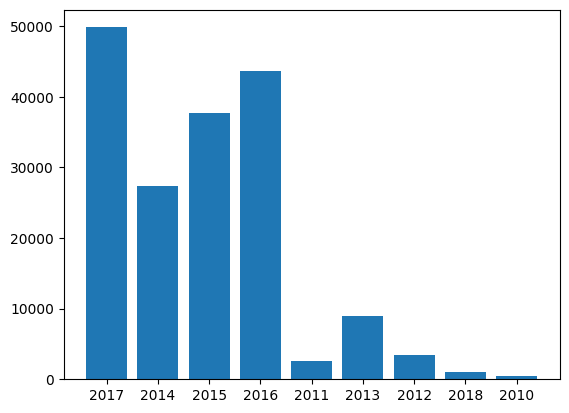

In [213]:
plt.bar(x=year_count.keys(), height=year_count.values())

In [219]:
year_review['2010'][3]

{'hours': 63.5,
 'gameID': 'g66296428',
 'hours_transformed': 6.011227255423254,
 'early_access': False,
 'date': '2010-11-27',
 'text': 'Bioware follows up with the success of Mass Effect with this EPICLY WONDERFUL sequel!!! Mass Effect 2 improves upon the gameplay from the first game and further expands the narrative of the Mass Effect universe. No longer is exploration or managing equipment a tedious task. Instead the focus of Mass Effect 2 purely lies in the story that continously builds up to Cmdr. Shepard\'s "Final Mission." The gameplay still revolves around shoot \'n cover tactics, but the game\'s enhancements allow you to direct your squad making it more of a tactical third-person shooter than just a standard RPG. The story, gameplay, characters, graphics, locations, etc. make Mass Effect 2 THE GREATEST game I have ever played. Mass Effect 2 features several DLC packs that are available at Bioware\'s SocialNetwork and are well worth the investment for the full experience. Shou

In [177]:
month_analysis = defaultdict(list)
month_count = defaultdict(int)
for u,g,d in allHours:
    month = d['date'][5:7]
    month_analysis[month].append(d['hours'])
    month_count[month] += 1
month_analysis.keys()

dict_keys(['05', '01', '03', '06', '07', '11', '12', '08', '10', '09', '02', '04'])

In [179]:
# Average hours played in each month
for month in month_analysis:
    month_analysis[month] = sum(month_analysis[month]) / len(month_analysis[month])
month_analysis

defaultdict(list,
            {'05': 68.96121024734951,
             '01': 62.947670836738254,
             '03': 60.18789380530976,
             '06': 60.89043926082992,
             '07': 61.16173842908502,
             '11': 94.48328233134076,
             '12': 65.11318477251638,
             '08': 58.82914078674914,
             '10': 63.694643809523626,
             '09': 58.738308823529074,
             '02': 61.82269539078108,
             '04': 65.48642556110924})

Seems November is a hot month to play games! Many reviews, much higher average play time as well...

In [180]:
month_count

defaultdict(int,
            {'05': 11320,
             '01': 15907,
             '03': 11300,
             '06': 16505,
             '07': 16118,
             '11': 21241,
             '12': 21540,
             '08': 13524,
             '10': 13125,
             '09': 12240,
             '02': 11976,
             '04': 10203})

<BarContainer object of 12 artists>

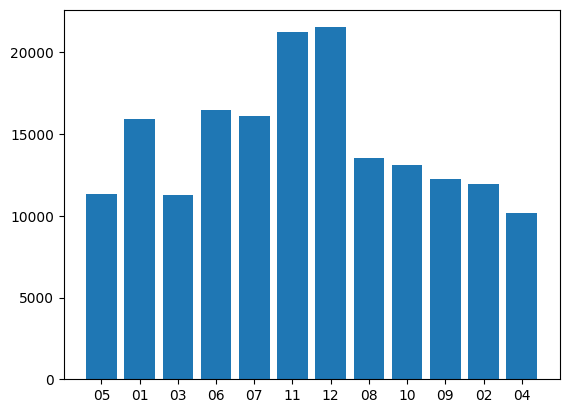

In [212]:
plt.bar(x=month_count.keys(), height=month_count.values())

In [197]:
day_analysis = defaultdict(list)
day_count = defaultdict(int)
for u,g,d in allHours:
    day = d['date'][8:10]
    day_analysis[day].append(d['hours'])
    day_count[day] += 1
day_analysis.keys()

dict_keys(['20', '27', '06', '13', '17', '14', '19', '15', '03', '01', '23', '07', '18', '24', '26', '31', '12', '11', '30', '09', '04', '22', '10', '25', '28', '02', '05', '08', '16', '21', '29'])

In [198]:
# Average hours played in each day
for day in day_analysis:
    day_analysis[day] = sum(day_analysis[day]) / len(day_analysis[day])

<BarContainer object of 31 artists>

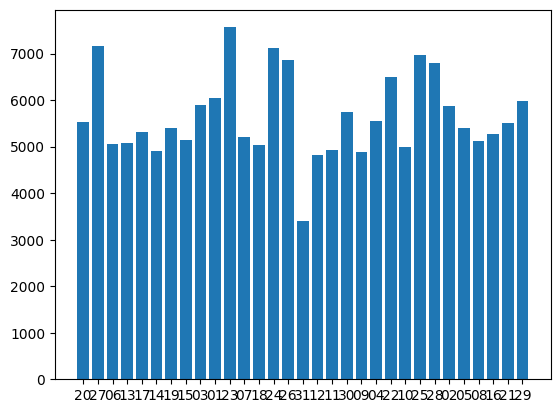

In [210]:
plt.bar(x=day_count.keys(), height=day_count.values())

### Potential Idea: do a sentiment analysis on text data. Label sentiment as positive if hours played exceeds certain threshold. Maybe label as positive if funny is a key in the dictionary?

## Try Bayesian Personalized Ranking with TF

In [16]:
items = list(gameSet)
items[:3]

['g64348065', 'g88837385', 'g84476497']

In [17]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(gameSet)], stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userSet), K], stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(gameSet), K], stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb
    
    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p
    
    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))
    
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui
    
    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [18]:
optimizer = tf.keras.optimizers.Adam(0.1)

In [19]:
modelBPR = BPRbatch(5, 0.00001)

In [20]:
def trainingStepBPR(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [],[],[]
        for _ in range(Nsamples):
            u,i,_ = random.choice(interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])
        
        loss = model(sampleU, sampleI, sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for 
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [21]:
# Run 100 batches of gradient descent
for i in range(150):
    obj = trainingStepBPR(modelBPR, interactions)
    if (i % 10 == 9): print("Iteration " + str(i+1) + ", objective = " + str(obj))

Iteration 10, objective = 0.5158729
Iteration 20, objective = 0.48454773
Iteration 30, objective = 0.46299976
Iteration 40, objective = 0.46121877
Iteration 50, objective = 0.46071127
Iteration 60, objective = 0.45233294
Iteration 70, objective = 0.45208198
Iteration 80, objective = 0.44801605
Iteration 90, objective = 0.44778994
Iteration 100, objective = 0.44628444
Iteration 110, objective = 0.44587696
Iteration 120, objective = 0.44281396
Iteration 130, objective = 0.44532016
Iteration 140, objective = 0.44657767
Iteration 150, objective = 0.44084668


In [24]:
interactionsTrain = interactions[:165000]
interactionsTest = interactions[165000:]

In [25]:
u,i,_ = interactionsTest[0]

In [26]:
# In this case just a score, rather than a prediction of a rating
modelBPR.predict(userIDs[u], itemIDs[i]).numpy()

1.1947993

In [272]:
Scores = []
negScore = []
for u,i,_ in interactionsTrain:
    score = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()
    Scores.append(score)
    if score < 0:
        negScore.append(score)

In [283]:
negScore.sort()
negScore.reverse()
negScore[int(len(negScore)*0.5)]

-0.34477544

In [27]:
interactionsTestPerUser = defaultdict(set)
itemSet = set()
for u,i,_ in interactionsTest:
    interactionsTestPerUser[u].add(i)
    itemSet.add(i)

In [28]:
def AUCu(u, N): # N samples per user
    win = 0
    if N > len(interactionsTestPerUser[u]):
        N = len(interactionsTestPerUser[u])
    positive = random.sample(interactionsTestPerUser[u],N)
    negative = random.sample(gameSet.difference(interactionsTestPerUser[u]),N)
    for i,j in zip(positive,negative):
        si = modelBPR.predict(userIDs[u], itemIDs[i]).numpy()
        sj = modelBPR.predict(userIDs[u], itemIDs[j]).numpy()
        if si > sj:
            win += 1
    return win/N

In [29]:
def AUC():
    av = []
    for u in interactionsTestPerUser:
        av.append(AUCu(u, 10))
    return sum(av) / len(av)

In [30]:
AUC()

/var/folders/8f/_6h5xprs32dfmm3jfs0g7k880000gn/T/ipykernel_6109/3135776419.py:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  positive = random.sample(interactionsTestPerUser[u],N)
/var/folders/8f/_6h5xprs32dfmm3jfs0g7k880000gn/T/ipykernel_6109/3135776419.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  negative = random.sample(gameSet.difference(interactionsTestPerUser[u]),N)


0.8349163876813394

In [331]:
correct = 0
scores = []
for u,g,_ in hoursTrain:
    score = modelBPR.predict(userIDs[u], itemIDs[g])
    scores.append(score)
    pred = 0
    if score > 0.5:
        pred = 1
    if pred == 1:
        correct += 1

In [333]:
correct / len(hoursTrain)

0.8101515151515152

In [26]:
predictions_scores = []
pred_user_items = defaultdict(list)
for l in open('pairs_Played.csv'):
    if l.startswith("userID"):
        continue
    u,g = l.strip().split(',')
    if u in userIDs and g in itemIDs:
        score = modelBPR.predict(userIDs[u], itemIDs[g]).numpy()
    elif g in return1:
        score = 100
    else:
        score = -100
    pred_user_items[u].append((g, score))
    predictions_scores.append((u,g,score))

In [27]:
pred_user_items

defaultdict(list,
            {'u04836696': [('g41031307', 1.3821051),
              ('g80808634', -0.63232684),
              ('g92711177', -1.8026829),
              ('g08102513', -1.1413542),
              ('g39176429', 0.63541925),
              ('g18529610', 0.5970859)],
             'u32377855': [('g62450068', -1.4920148),
              ('g58646191', 0.2728393),
              ('g06975986', -1.6668084),
              ('g10388657', -1.2227461),
              ('g56621675', 1.9265932),
              ('g15618317', -0.6190747),
              ('g42986038', -1.1106229),
              ('g50627654', 0.05818197),
              ('g22244120', 1.9830894),
              ('g28434261', -1.5524071),
              ('g46446145', 3.161926),
              ('g55811676', 1.5093493),
              ('g09929422', 0.56178933),
              ('g16246767', -0.15201434),
              ('g55997413', -1.1386212),
              ('g12079363', -2.2640095),
              ('g02637258', 1.7630062),
              ('g70

In [28]:
for key in pred_user_items:
    pred_user_items[key].sort(key=lambda x:x[1])
    pred_user_items[key].reverse()

In [29]:
pred_user_items

defaultdict(list,
            {'u04836696': [('g41031307', 1.3821051),
              ('g39176429', 0.63541925),
              ('g18529610', 0.5970859),
              ('g80808634', -0.63232684),
              ('g08102513', -1.1413542),
              ('g92711177', -1.8026829)],
             'u32377855': [('g46446145', 3.161926),
              ('g81608348', 2.660379),
              ('g02273341', 2.0571694),
              ('g22244120', 1.9830894),
              ('g56621675', 1.9265932),
              ('g34193208', 1.9031252),
              ('g02637258', 1.7630062),
              ('g85900991', 1.6358216),
              ('g55811676', 1.5093493),
              ('g57016851', 1.4788742),
              ('g23131507', 1.3105553),
              ('g22161219', 1.0874629),
              ('g70852781', 1.0780145),
              ('g95702441', 1.0141654),
              ('g78336897', 0.92413795),
              ('g09929422', 0.56178933),
              ('g58646191', 0.2728393),
              ('g50627654', 0.

In [47]:
predictions_scores.sort(key = lambda x: x[2]) 

In [31]:
positive_pairs = []
negative_pairs = []
for key in pred_user_items:
    for g,s in pred_user_items[key][:len(pred_user_items[key])//2]:
        positive_pairs.append((key,g))
    for g,s in pred_user_items[key][len(pred_user_items[key])//2:]:
        negative_pairs.append((key,g))

In [32]:
positive_pairs

[('u04836696', 'g41031307'),
 ('u04836696', 'g39176429'),
 ('u04836696', 'g18529610'),
 ('u32377855', 'g46446145'),
 ('u32377855', 'g81608348'),
 ('u32377855', 'g02273341'),
 ('u32377855', 'g22244120'),
 ('u32377855', 'g56621675'),
 ('u32377855', 'g34193208'),
 ('u32377855', 'g02637258'),
 ('u32377855', 'g85900991'),
 ('u32377855', 'g55811676'),
 ('u32377855', 'g57016851'),
 ('u32377855', 'g23131507'),
 ('u32377855', 'g22161219'),
 ('u32377855', 'g70852781'),
 ('u32377855', 'g95702441'),
 ('u32377855', 'g78336897'),
 ('u32377855', 'g09929422'),
 ('u32377855', 'g58646191'),
 ('u32377855', 'g50627654'),
 ('u58289072', 'g40551467'),
 ('u74685029', 'g16653801'),
 ('u06266052', 'g79499736'),
 ('u06266052', 'g77400036'),
 ('u06266052', 'g05546633'),
 ('u06266052', 'g84465937'),
 ('u45011836', 'g41467284'),
 ('u98484614', 'g35984506'),
 ('u98484614', 'g82194239'),
 ('u98484614', 'g09203234'),
 ('u98484614', 'g00131880'),
 ('u98484614', 'g24822320'),
 ('u98484614', 'g47915473'),
 ('u98484614',

In [33]:
predictions = open("predictions_Played.csv", 'w')
for l in open("pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    if (u,g) in positive_pairs:
        pred = 1
    else:
        pred = 0
    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()

## Sentiment analysis of review text

In [142]:
predictions = open("predictions_Played.csv", 'w')
for l in open("pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    maxSim = 0
    users = set(hoursPerItem[g])
    for g2,_ in hoursPerUser[u]:
        sim = Jaccard(users, hoursPerItem[g2])
        if sim > maxSim:
            maxSim = sim
    pred = 0
    if maxSim > 0.025 or len(hoursPerItem[g]) > 79.8:
        pred = 1
    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()

In [58]:
answers['Q5'] = "I confirm that I have uploaded an assignment submission to gradescope"

In [38]:
##################################################
# Hours played prediction                        #
##################################################

In [66]:
trainHours = [r[2]['hours_transformed'] for r in hoursTrain]
globalAverage = sum(trainHours) * 1.0 / len(hoursTrain)

In [67]:
validMSE = 0
for u,g,d in hoursValid:
    r = d['hours_transformed']
    se = (r- globalAverage)**2
    validMSE += se

validMSE /= len(hoursValid)

print("Validation MSE (average only) = " + str(validMSE))

Validation MSE (average only) = 5.316020858088501


In [133]:
### Question 6

In [69]:
betaU = {}
betaI = {}
for u in hoursPerUser:
    betaU[u] = 0

for g in hoursPerItem:
    betaI[g] = 0

In [79]:
alpha = globalAverage # Could initialize anywhere, this is a guess

In [80]:
def iterate(lamb):
    newAlpha = 0
    for u,g,d in hoursTrain:
        r = d['hours_transformed']
        newAlpha += r - (betaU[u] + betaI[g])
    alpha = newAlpha / len(hoursTrain)
    for u in hoursPerUser:
        newBetaU = 0
        for g,r in hoursPerUser[u]:
            newBetaU += r - (alpha + betaI[g])
        betaU[u] = newBetaU / (lamb + len(hoursPerUser[u]))
    for g in hoursPerItem:
        newBetaI = 0
        for u,r in hoursPerItem[g]:
            newBetaI += r - (alpha + betaU[u])
        betaI[g] = newBetaI / (lamb + len(hoursPerItem[g]))
    mse = 0
    for u,g,d in hoursTrain:
        r = d['hours_transformed']
        prediction = alpha + betaU[u] + betaI[g]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU:
        regularizer += betaU[u]**2
    for g in betaI:
        regularizer += betaI[g]**2
    mse /= len(hoursTrain)
    return mse, mse + lamb*regularizer

In [81]:
mse, objective = iterate(1)
newMSE, newObjective = iterate(1)
iterations = 2

In [82]:
while iterations < 10 or objective - newObjective > 0.01:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(1)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

Objective after 3 iterations = 6949.371887214059
MSE after 3 iterations = 2.7564084708391015
Objective after 4 iterations = 6969.457095076773
MSE after 4 iterations = 2.7556133685143775
Objective after 5 iterations = 6959.860929545761
MSE after 5 iterations = 2.755497315461903
Objective after 6 iterations = 6942.021172986504
MSE after 6 iterations = 2.755468887940564
Objective after 7 iterations = 6922.315789845392
MSE after 7 iterations = 2.7554572083332287
Objective after 8 iterations = 6902.457958240189
MSE after 8 iterations = 2.755449566226792
Objective after 9 iterations = 6882.895284113965
MSE after 9 iterations = 2.755443039374811
Objective after 10 iterations = 6863.740383717009
MSE after 10 iterations = 2.755436886252961
Objective after 11 iterations = 6845.017428754594
MSE after 11 iterations = 2.7554309119053677
Objective after 12 iterations = 6826.727196367468
MSE after 12 iterations = 2.755425063819739
Objective after 13 iterations = 6808.864265552004
MSE after 13 iterati

In [85]:
validMSE = 0
for u,g,d in hoursValid:
    r = d['hours_transformed']
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if g in betaI:
        bi = betaI[g]
    prediction = alpha + bu + bi
    validMSE += (r - prediction)**2

validMSE /= len(hoursValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 3.3620999448808417


In [86]:
answers['Q6'] = validMSE

In [87]:
assertFloat(answers['Q6'])

In [ ]:
### Question 7

In [88]:
betaUs = [(betaU[u], u) for u in betaU]
betaIs = [(betaI[i], i) for i in betaI]
betaUs.sort()
betaIs.sort()

print("Maximum betaU = " + str(betaUs[-1][1]) + ' (' + str(betaUs[-1][0]) + ')')
print("Maximum betaI = " + str(betaIs[-1][1]) + ' (' + str(betaIs[-1][0]) + ')')
print("Minimum betaU = " + str(betaUs[0][1]) + ' (' + str(betaUs[0][0]) + ')')
print("Minimum betaI = " + str(betaIs[0][1]) + ' (' + str(betaIs[0][0]) + ')')

Maximum betaU = u60898505 (5.828316004463382)
Maximum betaI = g17604638 (5.496003738829189)
Minimum betaU = u13037838 (-3.005788036433242)
Minimum betaI = g84397720 (-2.80929889234237)


In [90]:
answers['Q7'] = [betaUs[-1][0], betaUs[0][0], betaIs[-1][0], betaIs[0][0]]
answers['Q7']

[5.828316004463382, -3.005788036433242, 5.496003738829189, -2.80929889234237]

In [91]:
assertFloatList(answers['Q7'], 4)

In [ ]:
### Question 8

In [92]:
# Better lambda...

iterations = 1
while iterations < 10 or objective - newObjective > 0.01:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(5)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

Objective after 2 iterations = 23723.43363128721
MSE after 2 iterations = 2.7788622928906777
Objective after 3 iterations = 23510.614580035824
MSE after 3 iterations = 2.7795090635183897
Objective after 4 iterations = 23487.1358148199
MSE after 4 iterations = 2.7796328706435727
Objective after 5 iterations = 23482.629189140025
MSE after 5 iterations = 2.7796578901263955
Objective after 6 iterations = 23481.098216879294
MSE after 6 iterations = 2.7796656576503596
Objective after 7 iterations = 23480.151680333896
MSE after 7 iterations = 2.7796700570883783
Objective after 8 iterations = 23479.35821087336
MSE after 8 iterations = 2.7796736661690313
Objective after 9 iterations = 23478.632440801233
MSE after 9 iterations = 2.77967699001243
Objective after 10 iterations = 23477.955585702766
MSE after 10 iterations = 2.7796801315658564
Objective after 11 iterations = 23477.322147240444
MSE after 11 iterations = 2.779683113761583
Objective after 12 iterations = 23476.72930039359
MSE after 12 

In [93]:
alpha_ = alpha

In [94]:
validMSE = 0
for u,g,d in hoursValid:
    r = d['hours_transformed']
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if g in betaI:
        bi = betaI[g]
    prediction = alpha + bu + bi
    validMSE += (r - prediction)**2

validMSE /= len(hoursValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 3.3246508938026187


In [95]:
answers['Q8'] = (5.0, validMSE)
answers['Q8']

(5.0, 3.3246508938026187)

In [96]:
assertFloatList(answers['Q8'], 2)

In [99]:
predictions = open("predictions_Hours.csv", 'w')
for l in open("pairs_Hours.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if g in betaI:
        bi = betaI[g]
    _ = predictions.write(u + ',' + g + ',' + str(alpha + bu + bi) + '\n')

predictions.close()

In [98]:
f = open("answers_hw3.txt", 'w')
f.write(str(answers) + '\n')
f.close()